<a href="https://colab.research.google.com/github/Dana1402/NeuralNetworksScripts/blob/main/GAN_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

обучение DCGAN для генерации лиц и изучение латентного пространства.


иллюстрация архитектуры ([источник](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN) иллюстрации).

![alt text](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN/raw/master/tensorflow_DCGAN.png)

In [ ]:
import tensorflow as tf
# tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import time
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# добавлено сохранение весов, восстановление обучения, немного упрощен код

class DCGAN(tf.keras.Model):
    def __init__(self, image_size, output_path, num_channels=1, z_dim=100,
                 G_h_size=128, D_h_size=128):
        """
        image_size -- размер стороны квадратной картинки
        output_path -- путь для сохранения артефактов обучения. в корне -- картинки с разных итераций, в папке model -- модель
        num_channels -- количество каналов изображения
        z_dim -- размерность латентного вектора
        G_h_size -- минимальный размер фильтров с сверточных слоях генератора
        D_h_size -- минимальный размер фильтров с сверточных слоях дискриминатора
        """
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.multiply = int(np.log2(self.image_size / 8)) # столько раз нужно применить апсемплинг или даунсемплинг
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2) и наоборот
                                                
        self.output_path =  Path(output_path)
        (self.output_path / "model").mkdir(exist_ok=True)

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
         
        self.gen_loss_hist = []
        self.disc_loss_hist = []
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)
        self.start_iteration = 0

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):
        """
        Этот блок мы будем часто использовать -- поэтому вынесем его в отдельную функцию

        Он содержит Conv + BatchNorm + LeakyReLU

        При указании stride=2 -- уменьшит размер в два раза.
        """
        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
        

    def _build_generator(self):
        """
        Генератор должен превращать вектор длины self.z_dim в 
        картинку image_size x image_size x num_channels

        """
        
        model = tf.keras.Sequential()
        # для начала сделаем вектор -- трехмерным тензором м помощью Reshape
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))

        # Превратим его в тензор размера (4, 4, self.G_h_size * 2**self.multiply)
        model.add(Conv2DTranspose(self.G_h_size * 2**self.multiply,
                                  kernel_size=4, use_bias=False, 
                                  kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        
        for i in range(self.multiply):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 2**self.multiply // 2**(i+1))) # уменьшаем количество фильтров в два раза
        
        assert model.output_shape[1:] == (self.image_size // 2, self.image_size // 2, self.D_h_size), f"{model.output_shape, self.D_h_size}"
        
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        for i in range(self.multiply):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        assert model.output_shape[1:] == (4, 4, self.D_h_size * 2**self.multiply), f"{model.output_shape}"
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init, use_bias=False)) # без активации !
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):
        """
        Шаг обучения
        """
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def save_imgs(self, epoch):
        """
        Сохранение промежуточных картинок на диск
        """
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"{epoch}.png")
        plt.show()
    
    def train(self, dataset, num_iters=2000, show_every=25):
        """
        Цикл обучения
        """
        start = time.time()
        iters = self.start_iteration
        for image_batch in dataset:
            print(".", end='')
            gen_loss, disc_loss = self.train_step(image_batch)
            
            self.disc_loss_hist.append(disc_loss.numpy())
            self.gen_loss_hist.append(gen_loss.numpy())    
            
            if iters % show_every == 0:
                display.clear_output(wait=True)
                plt.figure()
                plt.plot(self.disc_loss_hist, label="Discriminator loss")
                plt.plot(self.gen_loss_hist, label="Generator loss")
                plt.legend(loc="best")
                plt.figure()
                self.save_imgs(f"{iters}")
                self.save_weights(str(self.output_path / "model" / "dcgan_model"), save_format='tf')
                
                print(f"\n{iters}/{num_iters}")
                print(f'Time elapsed from start {time.time() - start} sec')
                
            iters += 1
            if iters > num_iters:
                print(f'Finished. Time elapsed from start {time.time() - start} sec')
                return
        


## Загрузка датасета

In [ ]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/content/drive/MyDrive/HW_DCGAN/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /content/drive/MyDrive/HW_DCGAN/tmp/UTKFace.tar.gz -C /tmp/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /content/drive/MyDrive/HW_DCGAN/tmp/UTKFace.tar.gz
100%|██████████| 107M/107M [00:00<00:00, 146MB/s] 


In [ ]:
# import tarfile
# tar = tarfile.open("/content/drive/MyDrive/HW_DCGAN/tmp/UTKFace.tar.gz", "r")
# tar.extractall()
# tar.extractall(r"/content/drive/MyDrive/HW_DCGAN/tmp/UTKFace/")

## Создание генераторов данных

Данные расположены в папке "/tmp/UTKFace".

*Интенсивности картинок должны быть нормализованы от -1 до 1.*

In [ ]:
BATCH_SIZE = 128
IMAGE_SIZE = 32

In [ ]:
# import os
# os.listdir("/content/drive/MyDrive/HW_DCGAN/tmp/UTKFace.tar.gz/")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def preprocess_input_facenet(image):
    preprocessed = (image - 127.5) / 127.5 

    return preprocessed

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)
image_generator = image_gen.flow_from_directory("/content/drive/MyDrive/HW_DCGAN/tmp/UTKFace/",                         
                                                     target_size =(IMAGE_SIZE,IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,    
                                                     shuffle = True,
                                                     class_mode=None)

Found 23708 images belonging to 1 classes.


Shape test passed


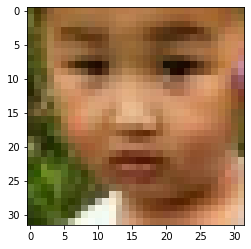

In [ ]:
sample = next(image_generator)
assert sample.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), f"Размер батча должен быть: {(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)}.  Получен {sample.shape}"
print("Shape test passed")
# если препроцессинг правильный, то картинка ниже имеет реалистичные цвета и matplotlib не ругается
plt.imshow((sample[0] + 1.) / 2)

## Обучение DCGAN

Обучение GAN. С указанными параметрами оно займет около часа.

In [ ]:
# Для того, чтобы сохранять прогресс и веса модели, будем использовать google drive -- так модель не потеряется
# и в случае отключения Colab в сможете продолжить обучение.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output = Path("/content/drive/My Drive/gan_utk_32")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

gan = DCGAN(image_size=IMAGE_SIZE, num_channels=3, output_path=output, 
           z_dim=100, D_h_size=128, G_h_size=128)

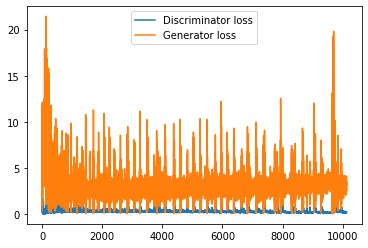

<Figure size 432x288 with 0 Axes>

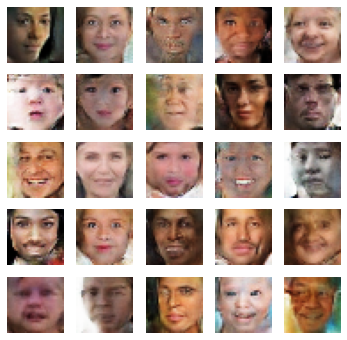


10000/10000
Time elapsed from start 3875.234867334366 sec
Finished. Time elapsed from start 3875.2349350452423 sec


In [ ]:
images = list(output.glob("*.png"))
if images: # если папка не пуста, то продолжим обучение с последней итерации
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan.train(image_generator, 10000, 50)

После того как модель обучена, можно посмотреть какие лица она научилась генерировать!

In [ ]:
def generate_data(latent_vector, generator):
    """
    Для того чтобы сгенерировать объект нам нужен генератор и латентный вектор
    """
    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

Вектор:  [-0.3289334  -0.04780674  0.35802263  0.5383081   0.7865908   0.35998008
 -0.8028942  -0.27028298  0.34209648 -1.0190724 ]


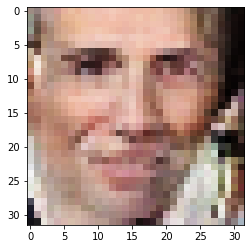

In [ ]:
v1 = tf.random.normal([1, 100]) # случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0]) # сгенерированное лицо, попробуйте сгенерировать несколько. 
                                                    # они должны получаться достаточно реалистичными

## Поиск вектора улыбки

Как мы уже знаем, GAN генерирует данные из случайных векторов из определенного распределения. Такие вектора образуют латентное пространство. 

Есть определенная комбинация чисел, прибавив которую к вектору соответствующему нейтральному лицу можно получить это же лицо, только с улыбкой. Эти числа мы и называем “вектор улыбки”. 


In [ ]:
# вспомогательный код
def generate_many(generator, n):
    vis_noise = np.random.normal(0, 1, (n, 100)).astype(np.float32)
    gen_imgs = generator(vis_noise, training=False)
    show_many(gen_imgs, "Generated images")
    return vis_noise

def show_many(images, title=""):
    w = h = int(np.sqrt(len(images)))
    images = (np.clip(images, -1, 1) + 1.) / 2. 
    
    fig, axs = plt.subplots(w, h, figsize=(w, h))
    if title != "":
        fig.suptitle(title)

    cnt = 0
    for i in range(h):
        for j in range(w):
            axs[i, j].imshow(images[cnt, :, :, :])
            axs[i, j].set_title(f"{cnt}")
            axs[i, j].axis('off')
            cnt += 1
    plt.subplots_adjust(wspace=.5)
    

### a) Интерполяция
Функция show_interpolation - для отображения превращения лица соответствующего латентному вектору `v_1` в лицо, соответствующее `v_2`. 
Вектора определены случайно из правильного распределения.



In [ ]:
def show_interpolation(v_1, v_2, generator, n=20):
    """
    Превращает v_1 в v_2 за n шагов, изображая 
    картинки соответствующие промежуточным векторам

    """
    fig, axs = plt.subplots(1, n, figsize=(n,1))
    for i, alpha in enumerate(np.linspace(0, 1, n)):
        curr_vec = v_1 * (1-alpha) + v_2 * alpha
        image = generate_data(curr_vec, gan.generator)[0]
        axs[i].imshow(image)
        axs[i].axis('off')

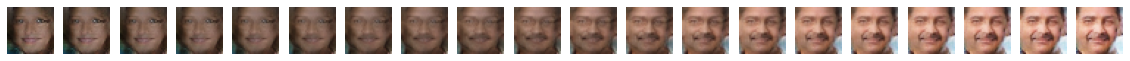

In [ ]:
v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])

show_interpolation(v1, v2, image_generator)

## b) Поиск вектора улыбки

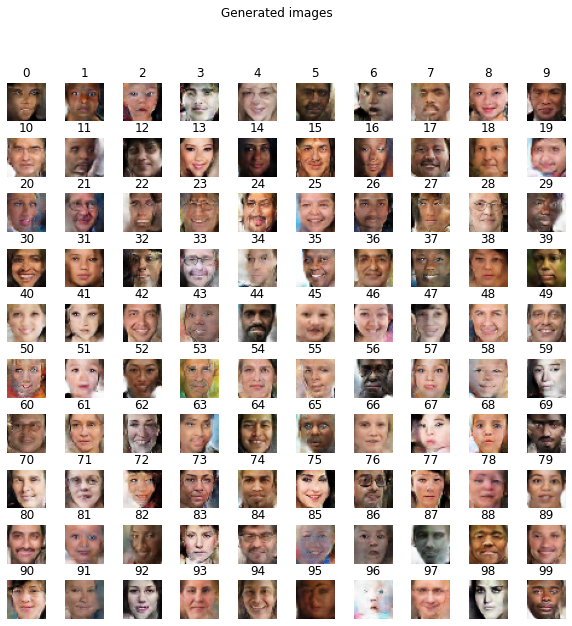

In [ ]:
samples = generate_many(gan.generator, 100)

In [ ]:
# поиск вектора улыбки
smiling_ppl = [samples[27], samples[32], samples[33], samples[40], samples[45], samples[47], samples[52], samples[72], samples[90], samples[50]]
neutral_ppl = [samples[11], samples[12], samples[15], samples[51], samples[61], samples[69], samples[70], samples[71], samples[76], samples[87]]

mean_smiling_vec = (sum(smiling_ppl))/len(smiling_ppl)
mean_neutral_ppl = (sum(neutral_ppl))/len(neutral_ppl)

smiling_vector = mean_smiling_vec - mean_neutral_ppl

In [ ]:
import cv2

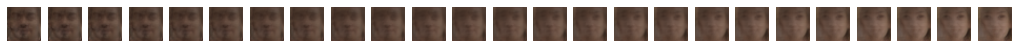

In [ ]:
# нейтральный человек ------> с улыбкой
v1 = mean_neutral_ppl.reshape(1, 100)
v2 = mean_smiling_vec.reshape(1, 100)

n = 25
fig, axs = plt.subplots(1, n, figsize=(18,4))
for i, alpha in enumerate(np.linspace(0, 1, n)):
    curr_vec = v1 * (1-alpha) + v2 * alpha
    image = generate_data(curr_vec, gan.generator)[0]
    axs[i].imshow(image)
    axs[i].axis('off')



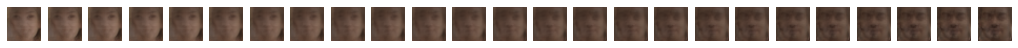

In [ ]:
# человек с улыбкой ------> нейтральный
v1 = mean_smiling_vec.reshape(1, 100)
v2 = mean_neutral_ppl.reshape(1, 100)

n = 25
fig, axs = plt.subplots(1, n, figsize=(18,4))
for i, alpha in enumerate(np.linspace(0, 1, n)):
    curr_vec = v1 * (1-alpha) + v2 * alpha
    image = generate_data(curr_vec, gan.generator)[0]
    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')